c:\Users\D MADHAN MOHAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
95/95 - 3s - 28ms/step - loss: 0.0427
Epoch 2/100
95/95 - 0s - 4ms/step - loss: 0.0205
Epoch 3/100
95/95 - 0s - 3ms/step - loss: 0.0159
Epoch 4/100
95/95 - 0s - 3ms/step - loss: 0.0146
Epoch 5/100
95/95 - 0s - 2ms/step - loss: 0.0136
Epoch 6/100
95/95 - 0s - 3ms/step - loss: 0.0125
Epoch 7/100
95/95 - 0s - 3ms/step - loss: 0.0114
Epoch 8/100
95/95 - 0s - 3ms/step - loss: 0.0104
Epoch 9/100
95/95 - 0s - 3ms/step - loss: 0.0093
Epoch 10/100
95/95 - 0s - 3ms/step - loss: 0.0083
Epoch 11/100
95/95 - 0s - 3ms/step - loss: 0.0073
Epoch 12/100
95/95 - 0s - 3ms/step - loss: 0.0064
Epoch 13/100
95/95 - 0s - 3ms/step - loss: 0.0055
Epoch 14/100
95/95 - 0s - 3ms/step - loss: 0.0047
Epoch 15/100
95/95 - 0s - 3ms/step - loss: 0.0041
Epoch 16/100
95/95 - 0s - 3ms/step - loss: 0.0035
Epoch 17/100
95/95 - 0s - 3ms/step - loss: 0.0031
Epoch 18/100
95/95 - 0s - 3ms/step - loss: 0.0027
Epoch 19/100
95/95 - 0s - 4ms/step - loss: 0.0025
Epoch 20/100
95/95 - 1s - 6ms/step - loss: 0.0023
Epoch 21

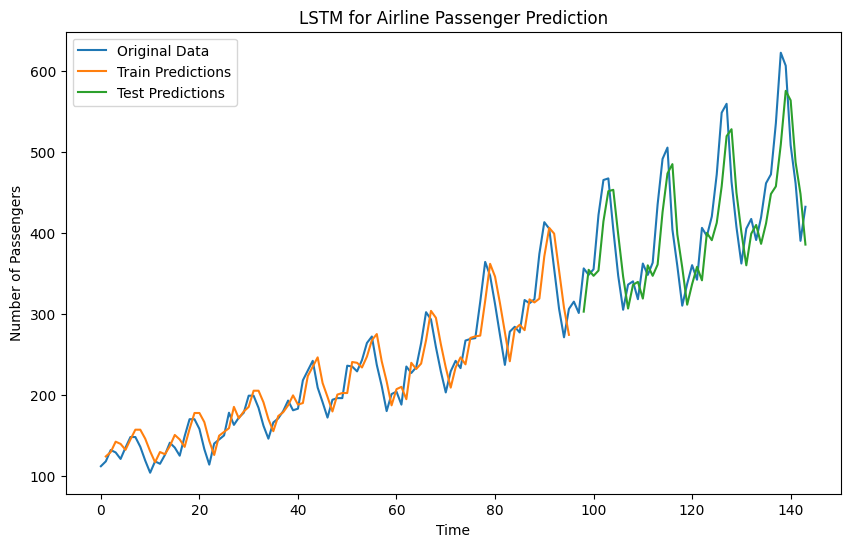

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import os

# Set random seed for reproducibility
tf.random.set_seed(7)

# Helper function to convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Load the dataset
file_path = os.path.join(os.getcwd(), 'international-airline-passengers.csv')
dataframe = read_csv(file_path, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network
model = Sequential([
    LSTM(4, input_shape=(1, look_back)),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print(f'Test Score: {testScore:.2f} RMSE')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.title('LSTM for Airline Passenger Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()